Group 25 Project

Doris (33996984)

Verness Chin (52924784)

Mackenzie Dy (62709126)

Kunyue Liu (94258175)


# Title: Heart Failure

## Introduction
Around 17 million people in the world die of cardiovascular diseases every year, most of whom are bearing myocardial infractions and heart failures. Cardiovascular Diseases refer to the disorders of the heart and blood vessels, such as heart attacks, stroke, and heart failure. Of all the cardiovascular diseases, heart failure is one of the most common and risky ones. Heart failure refers to a condition in which the heart can’t pump enough blood for the body. According to research, patients who experience heart failure bear higher risks of mortality compared to patients without HF. We are going to explore which specific variables can be used to predict the death event for patients with HF. 

The dataset we selected includes medical records of 299 patients with heart failure. The dataset has 11 columns, of which, except for the age of patients, all the variables can be classified as quantitative or categorical. Of all the variables, we select several quantitative features as potential predictors based on background research. 

Based on the dataset we have, we selected creatinine phosphokinase, ejection fraction, platelets, serum creatinine, and serum sodium as potential predictors for several reasons. Firstly, an obvious risky factor contributing to HF is ejection fraction. It’s common sense that when recommending treatments in medical practices, heart failure can be subcategorized according to ejection fraction. So, ejection fraction is one of the key variables when we consider HF. Also several conditions are also seen as symptoms of heart failure and thus contribute to mortality. High CPK caused by damaged muscle tissue always indicates heart failure or injury. The easiness of bleeding caused by low platelets is one of the dimensions of heart failure. Secondly, research shows that HF will increase ESRD and rates of mortality for patients with CKD. Even minimal changes in serum creatinine of patients with HF after surgeries will cause differences in mortality. In other words, it shows a close association between CKD and heart failure. Serum sodium is tested to be an important feature with respect to heart failure. So, as targets to assess the degree of CKD, serum creatinine and serum sodium are selected to predict the death event of patients with HF. 

We are going to incorporate the methodology of K-nearest neighbors to answer the question. After comparing different combinations of selected features, we will choose the most optimistic one to build a classification model and conduct the prediction.


In [145]:
# pip install -U scikit-learn
# pip install matplotlib
# pip install ucimlrepo

## Methods and Results

In [4]:
import altair as alt
import numpy as np
import pandas as pd
from sklearn import set_config
from sklearn.compose import make_column_transformer
from sklearn.model_selection import (
    GridSearchCV,
    train_test_split,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Simplify working with large datasets in Altair
alt.data_transformers.disable_max_rows()

# Output dataframes instead of arrays
set_config(transform_output="pandas")

Below, we read the data from the original source on the web.

In [5]:
url = 'https://archive.ics.uci.edu/static/public/519/data.csv'
data = pd.read_csv(url)
data

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,death_event
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


In this analysis, we will be focusing on quantitative variables rather than the boolean variables as that is the subject of our attention.

We've also converted the death event to a more readable format (yes and no).

In [6]:
data["death_event"] = data["death_event"].astype(str).replace({
    '1': 'Yes',
    '0': 'No'
})
data[['creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'death_event']]

,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,death_event
0,582,20,265000.00,1.9,130,Yes
1,7861,38,263358.03,1.1,136,Yes
2,146,20,162000.00,1.3,129,Yes
3,111,20,210000.00,1.9,137,Yes
4,160,20,327000.00,2.7,116,Yes
...,...,...,...,...,...,...
294,61,38,155000.00,1.1,143,No
295,1820,38,270000.00,1.2,139,No
296,2060,60,742000.00,0.8,138,No
297,2413,38,140000.00,1.4,140,No


This is where we split the data into the test (25%) and training data (75%).

In [7]:
heart_disease_train, heart_disease_test = train_test_split(data, test_size=0.25, random_state=123)

For our preferred analysis, we want two variables that will help us accurately predict a death event. However, we cannot randomly select a pair of variables, as there could exist another pair of variables that might predict the death event more accurately. To solve this, we will compare all possible pairs and determine which one has the higher accuracy.

Below, we initialize a dataframe to store all the possible pairs and their accuracies.

In [8]:
compared_categories_dataframe = pd.DataFrame(columns=['category_1', 'category_2', 'accuracy'])

### Comparison of Ejection Fraction and Serum Creatinine

In order to find the best value of <i>K</i> for the KNeighborsClassifier, we first initialize the preprocessor (to standardize the values) and the parameter grid (with a range of 1 to 49).

In [9]:
compared_categories = ['ejection_fraction', 'serum_creatinine']

heart_disease_preprocessor = make_column_transformer(
     (StandardScaler(), compared_categories),
     remainder= 'passthrough',
     verbose_feature_names_out=False,
)

parameter_grid = {
    "kneighborsclassifier__n_neighbors": range(1, 50, 1),
}

In optimizing our model, we devised a sophisticated pipeline that integrates preprocessing and classification components. Employing the GridSearchCV methodology, we fine-tuned our model's hyperparameters with a choice of 5 folds for cross-validation on the training set. Through this process, we computed mean test scores for varying values of the hyperparameter <i>K</i>. Our objective was to pinpoint the <i>K</i> that maximized the test score, thereby ensuring optimal predictive performance. 

In [11]:
heart_disease_pipeline = make_pipeline(heart_disease_preprocessor, KNeighborsClassifier())

heart_disease_tune_grid = GridSearchCV(
    estimator=heart_disease_pipeline,
    param_grid=parameter_grid,
    cv=5
)

accuracies_grid = pd.DataFrame(
    heart_disease_tune_grid.fit(
        heart_disease_train[compared_categories],
        heart_disease_train["death_event"]
    ).cv_results_
)

# makes the accuracies_grid easier to read
accuracies_grid = (
    accuracies_grid[[
        "param_kneighborsclassifier__n_neighbors",
        "mean_test_score",
        "std_test_score"
    ]]
    .assign(sem_test_score=accuracies_grid["std_test_score"] / 5**(1/2))
    .rename(columns={"param_kneighborsclassifier__n_neighbors": "n_neighbors"})
    .drop(columns=["std_test_score"])
)

# filters out the highest test score and returns the row
accuracies_grid.loc[accuracies_grid['mean_test_score'].idxmax()]

n_neighbors               8
mean_test_score    0.794646
sem_test_score     0.021199
Name: 7, dtype: object

Here is a plot that visually shows the <i>K</i> value and its mean test score.

In [44]:
cross_val_plot = alt.Chart(accuracies_grid).mark_line(point=True).encode(
    x = alt.X("n_neighbors").title("Number of Neighbors (k)").scale(zero = False),
    y = alt.Y("mean_test_score").title("Accuracy").scale(zero = False)
)
cross_val_plot

alt.Chart(...)

As we can see above, the best <i>K</i> value is 8 with a mean test score of 0.79. We will use this <i>K</i> value to train a model on the training data, predict test values, and score the accuracy of the classifier.

In [12]:
n = 8
X = heart_disease_train[compared_categories]
y = heart_disease_train["death_event"]

heart_disease_fit = make_pipeline(heart_disease_preprocessor, KNeighborsClassifier(n_neighbors = n))
heart_disease_fit = heart_disease_fit.fit(X, y)

heart_disease_test_predictions = heart_disease_test.assign(
    predicted = heart_disease_fit.predict(heart_disease_test[compared_categories])
)

X_test = heart_disease_test_predictions[compared_categories]
y_test = heart_disease_test_predictions["death_event"]
heart_disease_prediction_accuracy = heart_disease_fit.score(X_test, y_test)
heart_disease_prediction_accuracy

0.64

Now that we have our accuracy score, we store it in a database for further analysis.

In [13]:
new_row = {"category_1" : "ejection_fraction", "category_2" : "serum_creatinine", "accuracy" : heart_disease_prediction_accuracy }
compared_categories_dataframe.loc[len(compared_categories_dataframe)] = new_row
compared_categories_dataframe

,category_1,category_2,accuracy
0,ejection_fraction,serum_creatinine,0.64


We will now repeat this process for all possible pairs.

### Comparsion of Ejection Fraction and Platelets

In [14]:
# the pair of variables we are now comparing
compared_categories = ['ejection_fraction', 'platelets']

heart_disease_preprocessor = make_column_transformer(
     (StandardScaler(), compared_categories),
     remainder= 'passthrough',
     verbose_feature_names_out=False,
)

parameter_grid = {
    "kneighborsclassifier__n_neighbors": range(1, 50, 1),
}

heart_disease_pipeline = make_pipeline(heart_disease_preprocessor, KNeighborsClassifier())

heart_disease_tune_grid = GridSearchCV(
    estimator=heart_disease_pipeline,
    param_grid=parameter_grid,
    cv=5
)

accuracies_grid = pd.DataFrame(
    heart_disease_tune_grid.fit(
        heart_disease_train[compared_categories],
        heart_disease_train["death_event"]
    ).cv_results_
)

# makes the accuracies_grid easier to read
accuracies_grid = (
    accuracies_grid[[
        "param_kneighborsclassifier__n_neighbors",
        "mean_test_score",
        "std_test_score"
    ]]
    .assign(sem_test_score=accuracies_grid["std_test_score"] / 5**(1/2))
    .rename(columns={"param_kneighborsclassifier__n_neighbors": "n_neighbors"})
    .drop(columns=["std_test_score"])
)

# filters out the highest test score and returns the row
accuracies_grid.loc[accuracies_grid['mean_test_score'].idxmax()]

n_neighbors              15
mean_test_score    0.776869
sem_test_score     0.015153
Name: 14, dtype: object

In [15]:
n = 15
X = heart_disease_train[compared_categories]
y = heart_disease_train["death_event"]

heart_disease_fit = make_pipeline(heart_disease_preprocessor, KNeighborsClassifier(n_neighbors = n))
heart_disease_fit = heart_disease_fit.fit(X, y)

heart_disease_test_predictions = heart_disease_test.assign(
    predicted = heart_disease_fit.predict(heart_disease_test[compared_categories])
)

X_test = heart_disease_test_predictions[compared_categories]
y_test = heart_disease_test_predictions["death_event"]
heart_disease_prediction_accuracy = heart_disease_fit.score(X_test, y_test)
heart_disease_prediction_accuracy

0.5733333333333334

In [16]:
new_row = {'category_1' : 'ejection_fraction', 'category_2' : 'platelets', 'accuracy' : heart_disease_prediction_accuracy }
compared_categories_dataframe.loc[len(compared_categories_dataframe)] = new_row
compared_categories_dataframe

,category_1,category_2,accuracy
0,ejection_fraction,serum_creatinine,0.640000
1,ejection_fraction,platelets,0.573333


### Comparison of Ejection Fraction and Serum Sodium

In [17]:
# the pair of variables we are now comparing
compared_categories = ['ejection_fraction', 'serum_sodium']

heart_disease_preprocessor = make_column_transformer(
     (StandardScaler(), compared_categories),
     remainder= 'passthrough',
     verbose_feature_names_out=False,
)

parameter_grid = {
    "kneighborsclassifier__n_neighbors": range(1, 50, 1),
}

heart_disease_pipeline = make_pipeline(heart_disease_preprocessor, KNeighborsClassifier())

heart_disease_tune_grid = GridSearchCV(
    estimator=heart_disease_pipeline,
    param_grid=parameter_grid,
    cv=5
)

accuracies_grid = pd.DataFrame(
    heart_disease_tune_grid.fit(
        heart_disease_train[compared_categories],
        heart_disease_train["death_event"]
    ).cv_results_
)

# makes the accuracies_grid easier to read
accuracies_grid = (
    accuracies_grid[[
        "param_kneighborsclassifier__n_neighbors",
        "mean_test_score",
        "std_test_score"
    ]]
    .assign(sem_test_score=accuracies_grid["std_test_score"] / 5**(1/2))
    .rename(columns={"param_kneighborsclassifier__n_neighbors": "n_neighbors"})
    .drop(columns=["std_test_score"])
)

# filters out the highest test score and returns the row
accuracies_grid.loc[accuracies_grid['mean_test_score'].idxmax()]

n_neighbors              21
mean_test_score    0.772323
sem_test_score     0.009687
Name: 20, dtype: object

In [18]:
n = 21
X = heart_disease_train[compared_categories]
y = heart_disease_train["death_event"]

heart_disease_fit = make_pipeline(heart_disease_preprocessor, KNeighborsClassifier(n_neighbors = n))
heart_disease_fit = heart_disease_fit.fit(X, y)

heart_disease_test_predictions = heart_disease_test.assign(
    predicted = heart_disease_fit.predict(heart_disease_test[compared_categories])
)

X_test = heart_disease_test_predictions[compared_categories]
y_test = heart_disease_test_predictions["death_event"]
heart_disease_prediction_accuracy = heart_disease_fit.score(X_test, y_test)
heart_disease_prediction_accuracy

0.6

In [19]:
new_row = {'category_1' : 'ejection_fraction', 'category_2' : 'serum_sodium', 'accuracy' : heart_disease_prediction_accuracy }
compared_categories_dataframe.loc[len(compared_categories_dataframe)] = new_row
compared_categories_dataframe

,category_1,category_2,accuracy
0,ejection_fraction,serum_creatinine,0.640000
1,ejection_fraction,platelets,0.573333
2,ejection_fraction,serum_sodium,0.600000


### Comparison of Ejection Fraction and Creatinine Phosphokinase

In [20]:
# the pair of variables we are now comparing
compared_categories = ['ejection_fraction', 'creatinine_phosphokinase']

heart_disease_preprocessor = make_column_transformer(
     (StandardScaler(), compared_categories),
     remainder= 'passthrough',
     verbose_feature_names_out=False,
)

parameter_grid = {
    "kneighborsclassifier__n_neighbors": range(1, 50, 1),
}

heart_disease_pipeline = make_pipeline(heart_disease_preprocessor, KNeighborsClassifier())

heart_disease_tune_grid = GridSearchCV(
    estimator=heart_disease_pipeline,
    param_grid=parameter_grid,
    cv=5
)

accuracies_grid = pd.DataFrame(
    heart_disease_tune_grid.fit(
        heart_disease_train[compared_categories],
        heart_disease_train["death_event"]
    ).cv_results_
)

# makes the accuracies_grid easier to read
accuracies_grid = (
    accuracies_grid[[
        "param_kneighborsclassifier__n_neighbors",
        "mean_test_score",
        "std_test_score"
    ]]
    .assign(sem_test_score=accuracies_grid["std_test_score"] / 5**(1/2))
    .rename(columns={"param_kneighborsclassifier__n_neighbors": "n_neighbors"})
    .drop(columns=["std_test_score"])
)

# filters out the highest test score and returns the row
accuracies_grid.loc[accuracies_grid['mean_test_score'].idxmax()]

n_neighbors              10
mean_test_score    0.781414
sem_test_score     0.009078
Name: 9, dtype: object

In [21]:
n = 10
X = heart_disease_train[compared_categories]
y = heart_disease_train["death_event"]

heart_disease_fit = make_pipeline(heart_disease_preprocessor, KNeighborsClassifier(n_neighbors = n))
heart_disease_fit = heart_disease_fit.fit(X, y)

heart_disease_test_predictions = heart_disease_test.assign(
    predicted = heart_disease_fit.predict(heart_disease_test[compared_categories])
)

X_test = heart_disease_test_predictions[compared_categories]
y_test = heart_disease_test_predictions["death_event"]
heart_disease_prediction_accuracy = heart_disease_fit.score(X_test, y_test)
heart_disease_prediction_accuracy

0.6133333333333333

In [22]:
new_row = {'category_1' : 'ejection_fraction', 'category_2' : 'creatinine_phosphokinase', 'accuracy' : heart_disease_prediction_accuracy }
compared_categories_dataframe.loc[len(compared_categories_dataframe)] = new_row
compared_categories_dataframe

,category_1,category_2,accuracy
0,ejection_fraction,serum_creatinine,0.640000
1,ejection_fraction,platelets,0.573333
2,ejection_fraction,serum_sodium,0.600000
3,ejection_fraction,creatinine_phosphokinase,0.613333


### Comparison of Creatinine Phosphokinase and Serum Creatinine

In [23]:
# the pair of variables we are now comparing
compared_categories = ['creatinine_phosphokinase', 'serum_creatinine']

heart_disease_preprocessor = make_column_transformer(
     (StandardScaler(), compared_categories),
     remainder= 'passthrough',
     verbose_feature_names_out=False,
)

parameter_grid = {
    "kneighborsclassifier__n_neighbors": range(1, 50, 1),
}

heart_disease_pipeline = make_pipeline(heart_disease_preprocessor, KNeighborsClassifier())

heart_disease_tune_grid = GridSearchCV(
    estimator=heart_disease_pipeline,
    param_grid=parameter_grid,
    cv=5
)

accuracies_grid = pd.DataFrame(
    heart_disease_tune_grid.fit(
        heart_disease_train[compared_categories],
        heart_disease_train["death_event"]
    ).cv_results_
)

# makes the accuracies_grid easier to read
accuracies_grid = (
    accuracies_grid[[
        "param_kneighborsclassifier__n_neighbors",
        "mean_test_score",
        "std_test_score"
    ]]
    .assign(sem_test_score=accuracies_grid["std_test_score"] / 5**(1/2))
    .rename(columns={"param_kneighborsclassifier__n_neighbors": "n_neighbors"})
    .drop(columns=["std_test_score"])
)

# filters out the highest test score and returns the row
accuracies_grid.loc[accuracies_grid['mean_test_score'].idxmax()]

n_neighbors              14
mean_test_score    0.749899
sem_test_score     0.017382
Name: 13, dtype: object

In [24]:
n = 14
X = heart_disease_train[compared_categories]
y = heart_disease_train["death_event"]

heart_disease_fit = make_pipeline(heart_disease_preprocessor, KNeighborsClassifier(n_neighbors = n))
heart_disease_fit = heart_disease_fit.fit(X, y)

heart_disease_test_predictions = heart_disease_test.assign(
    predicted = heart_disease_fit.predict(heart_disease_test[compared_categories])
)

X_test = heart_disease_test_predictions[compared_categories]
y_test = heart_disease_test_predictions["death_event"]
heart_disease_prediction_accuracy = heart_disease_fit.score(X_test, y_test)
heart_disease_prediction_accuracy

0.5866666666666667

In [25]:
new_row = {'category_1' : 'creatine_phosphokinase', 'category_2' : 'serum_creatine', 'accuracy' : heart_disease_prediction_accuracy }
compared_categories_dataframe.loc[len(compared_categories_dataframe)] = new_row
compared_categories_dataframe

,category_1,category_2,accuracy
0,ejection_fraction,serum_creatinine,0.640000
1,ejection_fraction,platelets,0.573333
2,ejection_fraction,serum_sodium,0.600000
3,ejection_fraction,creatinine_phosphokinase,0.613333
4,creatine_phosphokinase,serum_creatine,0.586667


### Comparison of Platelets with Serum Creatinine

In [26]:
# the pair of variables we are now comparing
compared_categories = ['platelets', 'serum_creatinine']

heart_disease_preprocessor = make_column_transformer(
     (StandardScaler(), compared_categories),
     remainder= 'passthrough',
     verbose_feature_names_out=False,
)

parameter_grid = {
    "kneighborsclassifier__n_neighbors": range(1, 50, 1),
}

heart_disease_pipeline = make_pipeline(heart_disease_preprocessor, KNeighborsClassifier())

heart_disease_tune_grid = GridSearchCV(
    estimator=heart_disease_pipeline,
    param_grid=parameter_grid,
    cv=5
)

accuracies_grid = pd.DataFrame(
    heart_disease_tune_grid.fit(
        heart_disease_train[compared_categories],
        heart_disease_train["death_event"]
    ).cv_results_
)

# makes the accuracies_grid easier to read
accuracies_grid = (
    accuracies_grid[[
        "param_kneighborsclassifier__n_neighbors",
        "mean_test_score",
        "std_test_score"
    ]]
    .assign(sem_test_score=accuracies_grid["std_test_score"] / 5**(1/2))
    .rename(columns={"param_kneighborsclassifier__n_neighbors": "n_neighbors"})
    .drop(columns=["std_test_score"])
)

# filters out the highest test score and returns the row
accuracies_grid.loc[accuracies_grid['mean_test_score'].idxmax()]

n_neighbors               7
mean_test_score    0.731919
sem_test_score     0.024886
Name: 6, dtype: object

In [27]:
n = 7
X = heart_disease_train[compared_categories]
y = heart_disease_train["death_event"]

heart_disease_fit = make_pipeline(heart_disease_preprocessor, KNeighborsClassifier(n_neighbors = n))
heart_disease_fit = heart_disease_fit.fit(X, y)

heart_disease_test_predictions = heart_disease_test.assign(
    predicted = heart_disease_fit.predict(heart_disease_test[compared_categories])
)

X_test = heart_disease_test_predictions[compared_categories]
y_test = heart_disease_test_predictions["death_event"]
heart_disease_prediction_accuracy = heart_disease_fit.score(X_test, y_test)
heart_disease_prediction_accuracy

0.6666666666666666

In [28]:
new_row = {'category_1' : 'platelets', 'category_2' : 'serum_creatinine', 'accuracy' : heart_disease_prediction_accuracy }
compared_categories_dataframe.loc[len(compared_categories_dataframe)] = new_row
compared_categories_dataframe

,category_1,category_2,accuracy
0,ejection_fraction,serum_creatinine,0.640000
1,ejection_fraction,platelets,0.573333
2,ejection_fraction,serum_sodium,0.600000
3,ejection_fraction,creatinine_phosphokinase,0.613333
4,creatine_phosphokinase,serum_creatine,0.586667
5,platelets,serum_creatinine,0.666667


### Comparison of Serum Creatinine and Serum Sodium

In [29]:
# the pair of variables we are now comparing
compared_categories = ['serum_creatinine', 'serum_sodium']

heart_disease_preprocessor = make_column_transformer(
     (StandardScaler(), compared_categories),
     remainder= 'passthrough',
     verbose_feature_names_out=False,
)

parameter_grid = {
    "kneighborsclassifier__n_neighbors": range(1, 50, 1),
}

heart_disease_pipeline = make_pipeline(heart_disease_preprocessor, KNeighborsClassifier())

heart_disease_tune_grid = GridSearchCV(
    estimator=heart_disease_pipeline,
    param_grid=parameter_grid,
    cv=5
)

accuracies_grid = pd.DataFrame(
    heart_disease_tune_grid.fit(
        heart_disease_train[compared_categories],
        heart_disease_train["death_event"]
    ).cv_results_
)

# makes the accuracies_grid easier to read
accuracies_grid = (
    accuracies_grid[[
        "param_kneighborsclassifier__n_neighbors",
        "mean_test_score",
        "std_test_score"
    ]]
    .assign(sem_test_score=accuracies_grid["std_test_score"] / 5**(1/2))
    .rename(columns={"param_kneighborsclassifier__n_neighbors": "n_neighbors"})
    .drop(columns=["std_test_score"])
)

# filters out the highest test score and returns the row
accuracies_grid.loc[accuracies_grid['mean_test_score'].idxmax()]

n_neighbors               7
mean_test_score    0.741212
sem_test_score     0.032815
Name: 6, dtype: object

In [30]:
n = 7
X = heart_disease_train[compared_categories]
y = heart_disease_train["death_event"]

heart_disease_fit = make_pipeline(heart_disease_preprocessor, KNeighborsClassifier(n_neighbors = n))
heart_disease_fit = heart_disease_fit.fit(X, y)

heart_disease_test_predictions = heart_disease_test.assign(
    predicted = heart_disease_fit.predict(heart_disease_test[compared_categories])
)

X_test = heart_disease_test_predictions[compared_categories]
y_test = heart_disease_test_predictions["death_event"]
heart_disease_prediction_accuracy = heart_disease_fit.score(X_test, y_test)
heart_disease_prediction_accuracy

0.7066666666666667

In [31]:
new_row = {'category_1' : 'serum_creatinine', 'category_2' : 'serum_sodium', 'accuracy' : heart_disease_prediction_accuracy }
compared_categories_dataframe.loc[len(compared_categories_dataframe)] = new_row
compared_categories_dataframe

,category_1,category_2,accuracy
0,ejection_fraction,serum_creatinine,0.640000
1,ejection_fraction,platelets,0.573333
2,ejection_fraction,serum_sodium,0.600000
3,ejection_fraction,creatinine_phosphokinase,0.613333
4,creatine_phosphokinase,serum_creatine,0.586667
5,platelets,serum_creatinine,0.666667
6,serum_creatinine,serum_sodium,0.706667


### Comparison of Creatinine Phosphokinase and Platelets

In [32]:
# the pair of variables we are now comparing
compared_categories = ['creatinine_phosphokinase', 'platelets']

heart_disease_preprocessor = make_column_transformer(
     (StandardScaler(), compared_categories),
     remainder= 'passthrough',
     verbose_feature_names_out=False,
)

parameter_grid = {
    "kneighborsclassifier__n_neighbors": range(1, 50, 1),
}

heart_disease_pipeline = make_pipeline(heart_disease_preprocessor, KNeighborsClassifier())

heart_disease_tune_grid = GridSearchCV(
    estimator=heart_disease_pipeline,
    param_grid=parameter_grid,
    cv=5
)

accuracies_grid = pd.DataFrame(
    heart_disease_tune_grid.fit(
        heart_disease_train[compared_categories],
        heart_disease_train["death_event"]
    ).cv_results_
)

# makes the accuracies_grid easier to read
accuracies_grid = (
    accuracies_grid[[
        "param_kneighborsclassifier__n_neighbors",
        "mean_test_score",
        "std_test_score"
    ]]
    .assign(sem_test_score=accuracies_grid["std_test_score"] / 5**(1/2))
    .rename(columns={"param_kneighborsclassifier__n_neighbors": "n_neighbors"})
    .drop(columns=["std_test_score"])
)

# filters out the highest test score and returns the row
accuracies_grid.loc[accuracies_grid['mean_test_score'].idxmax()]

n_neighbors              14
mean_test_score    0.714242
sem_test_score     0.004418
Name: 13, dtype: object

In [33]:
n = 14
X = heart_disease_train[compared_categories]
y = heart_disease_train["death_event"]

heart_disease_fit = make_pipeline(heart_disease_preprocessor, KNeighborsClassifier(n_neighbors = n))
heart_disease_fit = heart_disease_fit.fit(X, y)

heart_disease_test_predictions = heart_disease_test.assign(
    predicted = heart_disease_fit.predict(heart_disease_test[compared_categories])
)

X_test = heart_disease_test_predictions[compared_categories]
y_test = heart_disease_test_predictions["death_event"]
heart_disease_prediction_accuracy = heart_disease_fit.score(X_test, y_test)
heart_disease_prediction_accuracy

0.5466666666666666

In [34]:
new_row = {'category_1' : 'creatinine_phosphokinase', 'category_2' : 'platelets', 'accuracy' : heart_disease_prediction_accuracy }
compared_categories_dataframe.loc[len(compared_categories_dataframe)] = new_row
compared_categories_dataframe

,category_1,category_2,accuracy
0,ejection_fraction,serum_creatinine,0.640000
1,ejection_fraction,platelets,0.573333
2,ejection_fraction,serum_sodium,0.600000
3,ejection_fraction,creatinine_phosphokinase,0.613333
4,creatine_phosphokinase,serum_creatine,0.586667
5,platelets,serum_creatinine,0.666667
6,serum_creatinine,serum_sodium,0.706667
7,creatinine_phosphokinase,platelets,0.546667


### Comparison of Creatinine Phosphokinase and Serum Sodium

In [35]:
# the pair of variables we are now comparing
compared_categories = ['creatinine_phosphokinase', 'serum_sodium']

heart_disease_preprocessor = make_column_transformer(
     (StandardScaler(), compared_categories),
     remainder= 'passthrough',
     verbose_feature_names_out=False,
)

parameter_grid = {
    "kneighborsclassifier__n_neighbors": range(1, 50, 1),
}

heart_disease_pipeline = make_pipeline(heart_disease_preprocessor, KNeighborsClassifier())

heart_disease_tune_grid = GridSearchCV(
    estimator=heart_disease_pipeline,
    param_grid=parameter_grid,
    cv=5
)

accuracies_grid = pd.DataFrame(
    heart_disease_tune_grid.fit(
        heart_disease_train[compared_categories],
        heart_disease_train["death_event"]
    ).cv_results_
)

# makes the accuracies_grid easier to read
accuracies_grid = (
    accuracies_grid[[
        "param_kneighborsclassifier__n_neighbors",
        "mean_test_score",
        "std_test_score"
    ]]
    .assign(sem_test_score=accuracies_grid["std_test_score"] / 5**(1/2))
    .rename(columns={"param_kneighborsclassifier__n_neighbors": "n_neighbors"})
    .drop(columns=["std_test_score"])
)

# filters out the highest test score and returns the row
accuracies_grid.loc[accuracies_grid['mean_test_score'].idxmax()]

n_neighbors              17
mean_test_score    0.723434
sem_test_score     0.012688
Name: 16, dtype: object

In [36]:
n = 17
X = heart_disease_train[compared_categories]
y = heart_disease_train["death_event"]

heart_disease_fit = make_pipeline(heart_disease_preprocessor, KNeighborsClassifier(n_neighbors = n))
heart_disease_fit = heart_disease_fit.fit(X, y)

heart_disease_test_predictions = heart_disease_test.assign(
    predicted = heart_disease_fit.predict(heart_disease_test[compared_categories])
)

X_test = heart_disease_test_predictions[compared_categories]
y_test = heart_disease_test_predictions["death_event"]
heart_disease_prediction_accuracy = heart_disease_fit.score(X_test, y_test)
heart_disease_prediction_accuracy

0.6266666666666667

In [37]:
new_row = {'category_1' : 'creatinine_phosphokinase', 'category_2' : 'serum_sodium', 'accuracy' : heart_disease_prediction_accuracy }
compared_categories_dataframe.loc[len(compared_categories_dataframe)] = new_row
compared_categories_dataframe

,category_1,category_2,accuracy
0,ejection_fraction,serum_creatinine,0.640000
1,ejection_fraction,platelets,0.573333
2,ejection_fraction,serum_sodium,0.600000
3,ejection_fraction,creatinine_phosphokinase,0.613333
4,creatine_phosphokinase,serum_creatine,0.586667
5,platelets,serum_creatinine,0.666667
6,serum_creatinine,serum_sodium,0.706667
7,creatinine_phosphokinase,platelets,0.546667
8,creatinine_phosphokinase,serum_sodium,0.626667


### Comparison of Platelets and Serum Sodium

In [38]:
# the pair of variables we are now comparing
compared_categories = ['platelets', 'serum_sodium']

heart_disease_preprocessor = make_column_transformer(
     (StandardScaler(), compared_categories),
     remainder= 'passthrough',
     verbose_feature_names_out=False,
)

parameter_grid = {
    "kneighborsclassifier__n_neighbors": range(1, 50, 1),
}

heart_disease_pipeline = make_pipeline(heart_disease_preprocessor, KNeighborsClassifier())

heart_disease_tune_grid = GridSearchCV(
    estimator=heart_disease_pipeline,
    param_grid=parameter_grid,
    cv=5
)

accuracies_grid = pd.DataFrame(
    heart_disease_tune_grid.fit(
        heart_disease_train[compared_categories],
        heart_disease_train["death_event"]
    ).cv_results_
)

# makes the accuracies_grid easier to read
accuracies_grid = (
    accuracies_grid[[
        "param_kneighborsclassifier__n_neighbors",
        "mean_test_score",
        "std_test_score"
    ]]
    .assign(sem_test_score=accuracies_grid["std_test_score"] / 5**(1/2))
    .rename(columns={"param_kneighborsclassifier__n_neighbors": "n_neighbors"})
    .drop(columns=["std_test_score"])
)

# filters out the highest test score and returns the row
accuracies_grid.loc[accuracies_grid['mean_test_score'].idxmax()]

n_neighbors              20
mean_test_score    0.714242
sem_test_score     0.009926
Name: 19, dtype: object

In [39]:
n = 20
X = heart_disease_train[compared_categories]
y = heart_disease_train["death_event"]

heart_disease_fit = make_pipeline(heart_disease_preprocessor, KNeighborsClassifier(n_neighbors = n))
heart_disease_fit = heart_disease_fit.fit(X, y)

heart_disease_test_predictions = heart_disease_test.assign(
    predicted = heart_disease_fit.predict(heart_disease_test[compared_categories])
)

X_test = heart_disease_test_predictions[compared_categories]
y_test = heart_disease_test_predictions["death_event"]
heart_disease_prediction_accuracy = heart_disease_fit.score(X_test, y_test)
heart_disease_prediction_accuracy

0.6

In [40]:
new_row = {'category_1' : 'platelets', 'category_2' : 'serum_sodium', 'accuracy' : heart_disease_prediction_accuracy }
compared_categories_dataframe.loc[len(compared_categories_dataframe)] = new_row
compared_categories_dataframe

,category_1,category_2,accuracy
0,ejection_fraction,serum_creatinine,0.640000
1,ejection_fraction,platelets,0.573333
2,ejection_fraction,serum_sodium,0.600000
3,ejection_fraction,creatinine_phosphokinase,0.613333
4,creatine_phosphokinase,serum_creatine,0.586667
5,platelets,serum_creatinine,0.666667
6,serum_creatinine,serum_sodium,0.706667
7,creatinine_phosphokinase,platelets,0.546667
8,creatinine_phosphokinase,serum_sodium,0.626667
9,platelets,serum_sodium,0.600000


Having went through all the possible pairs, we see from the table that the category of Serum Creatinine and Serum Sodium produces the highest accuracy score out of all the other possible pairs. Thus, **Serum Creatinine and Serum Sodium** is the pair we will use to further analyze how it affect the death event.

### Visuailzation of planned analysis

Below is a chart that visualizes the relationship between Ejection Fraction and Serum Creatinine and how they both relate to the death event.

In [41]:
plot = alt.Chart(data).mark_point(opacity = 0.5).encode(
    x = alt.X('serum_creatinine', title = "Ejection Fraction in percentage (%)"),
    y = alt.Y('serum_sodium', title = "Serum Creatinine in mg/dL").scale(zero=False),
     color = alt.Color('death_event', title = 'Death event')
)
plot

alt.Chart(...)

As we can tell from the plot, we can easily see why these two variables allow for such high accuracy when predicting the death event. The points in which the death event is negative are bunched together, making the work of the KNeighborsClassifier algorithm easier.

Here, we also compute the accuracy, precision, and recall of the classifier, using the optimal <i>K</i> value and training the model again to work with Serum Creatinine and Serum Sodium.

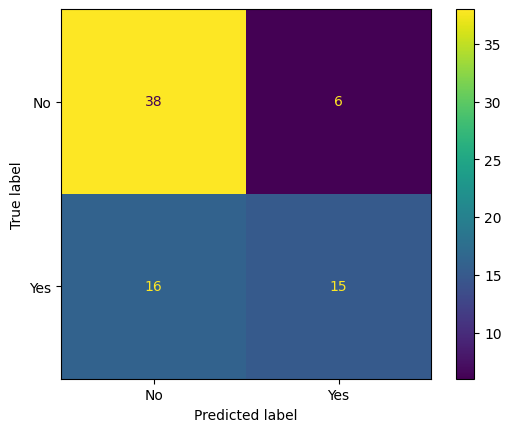

In [42]:
from sklearn.metrics import ConfusionMatrixDisplay
compared_categories = ['serum_creatinine', 'serum_sodium']

heart_disease_preprocessor = make_column_transformer(
     (StandardScaler(), compared_categories),
     remainder= 'passthrough',
     verbose_feature_names_out=False,
)

heart_disease_fit = make_pipeline(heart_disease_preprocessor, KNeighborsClassifier(n_neighbors = 7))
heart_disease_fit = heart_disease_fit.fit(
    heart_disease_train[compared_categories], 
    heart_disease_train["death_event"]
)

confusion_matrix = ConfusionMatrixDisplay.from_estimator(
    heart_disease_fit, 
    heart_disease_test_predictions[compared_categories], 
    heart_disease_test_predictions["death_event"]
)

In [43]:
accuracy = (38 + 15)/(38 + 6 + 16 + 15)
precision = (15)/(16 + 15)
recall = (15)/(15 + 6)
print("Accuracy:", accuracy, "Precision:", precision, "Recall:", recall)

Accuracy: 0.7066666666666667 Precision: 0.4838709677419355 Recall: 0.7142857142857143


From the confusion matrix, we can see that the accuracy is 70%, the precision is 48%, and the recall is 71%. This means that if our classifier predicts a death event, we can be 71% sure that this death event is going to be a death event.

## Reference
Chicco, D., & Jurman, G. (2020). Machine learning can predict survival of patients with heart 
failure from serum creatinine and ejection fraction alone. &nbsp;&nbsp;&nbsp;&nbsp;*BMC Medical Informatics and 
Decision Making, 20.*

Sud, M., Tangri, N., Pintilie, M., Levey, A. S., & Naimark, D. M. (2015). ESRD and death after heart failure in CKD. *Journal of the American Society of &nbsp;&nbsp;&nbsp;&nbsp;Nephrology: JASN, 26*(3), 715–722. https://doi.org/10.1681/ASN.2014030253

LASSNIGG, A., SCHMIDLIN, D., MOUHIEDDINE, M., BACHMANN, L. M., DRUML, W., BAUER, P., & HIESMAYR, M. (2004). Minimal changes of serum &nbsp;&nbsp;&nbsp;&nbsp;creatinine predict prognosis in patients after cardiothoracic surgery: A prospective cohort study. *Journal of the American Society of Nephrology, &nbsp;&nbsp;&nbsp;&nbsp;15*(6), 1597-1605. https://doi.org/10.1097/01.ASN.0000130340.93930.DD

Bozkurt, B. (2021). Universal definition and classification of heart failure: a report of the Heart Failure Society of America, Heart Failure Association of &nbsp;&nbsp;&nbsp;&nbsp;the European Society of Cardiology, Japanese Heart Failure Society and Writing Committee of the Universal Definition of Heart Failure Endorsed by &nbsp;&nbsp;&nbsp;&nbsp;the Canadian Heart Failure Society, Heart Failure Association of India, Cardiac Society of Australia and New Zealand, and Chinese Heart Failure &nbsp;&nbsp;&nbsp;&nbsp;Association. *European Journal of Heart Failure, 23*(3), 352-380. 10.1002/ejhf.2115